CIFAR10 - VGG11 solution

Install Keras just in case...

In [1]:
!pip3 install keras

Imports...

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Define batch size, number of epochs and number of classes


In [3]:
batch_size = 100
num_classes = 10
epochs = 75

Load MNIST and transform

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


DEFINE A DATA AUGMENTATION GENERATOR

> Bloque con sangría



In [5]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=45,
    vertical_flip=True)

DEF A BLOCK CONV + BN + GN

In [6]:
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))  
  
  return model

Define the NN topology, a sequential model with 2 hidden layers

In [7]:
model = Sequential()

model=CBGN(model,64,x_train.shape[1:])
model.add(MaxPooling2D(pool_size=(2, 2)))

model=CBGN(model,128)
model.add(MaxPooling2D(pool_size=(2, 2)))

model=CBGN(model,256)
model=CBGN(model,256)
model.add(MaxPooling2D(pool_size=(2, 2)))

model=CBGN(model,512)
model=CBGN(model,512)
model.add(MaxPooling2D(pool_size=(2, 2)))

model=CBGN(model,512)
model=CBGN(model,512)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       5

Define an optimizer 

In [8]:
opt = SGD(lr=0.1, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


DEFINE A LEARNING RATE SCHEDULER

In [9]:
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

# Callbacks
set_lr = LRS(scheduler)
es = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Compile the model, define loss and link the optimizer

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [11]:
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                  steps_per_epoch=len(x_train) / batch_size, 
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  callbacks=[set_lr, es],
                  verbose=1)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)


print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/75
500/500 [==============================] - 80s 64ms/step - loss: 2.1165 - accuracy: 0.2493 - val_loss: 2.1484 - val_accuracy: 0.2665
Epoch 2/75
500/500 [==============================] - 30s 60ms/step - loss: 1.6315 - accuracy: 0.4054 - val_loss: 1.7795 - val_accuracy: 0.4003
Epoch 3/75
500/500 [==============================] - 30s 60ms/step - loss: 1.4838 - accuracy: 0.4612 - val_loss: 1.4701 - val_accuracy: 0.5095
Epoch 4/75
500/500 [==============================] - 30s 60ms/step - loss: 1.3909 - accuracy: 0.5025 - val_loss: 1.2385 - val_accuracy: 0.5631
Epoch 5/75
500/500 [==============================] - 30s 60ms/step - loss: 1.3122 - accuracy: 0.5248 - val_loss: 1.1911 - val_accuracy: 0.5770
Epoch 6/75
500/500 [==============================] - 30s 60ms/step - loss: 1.2539 - accuracy: 0.5496 - val_loss: 1.4999 - val_accuracy: 0.4933
Epoch 7/75
500/500 [==============================] - 30s 60ms/step - loss: 1.2067 - accuracy: 0.5713 - val_loss: 1.4661 - val_accuracy:

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [13]:
import matplotlib.pyplot as plt

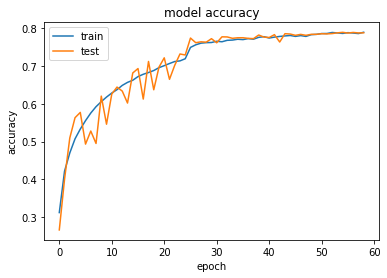

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()